In [2]:
import pandas as pd
import numpy as np


import os, sys
sys.path.append(os.path.abspath('..'))

import importlib
import python_scripts.config as cfg
importlib.reload(cfg)
from sqlalchemy import create_engine


from python_scripts.config import FINAL_P_SENSORS, FINAL_T_SENSORS
from python_scripts.data_preprocessing import (
    structural_clean, signal_clean, remove_outliers,
    normalize_signals, apply_rename, ensure_cols, add_total_load, detect_wear_by_temperature
)


## Load Data

In [3]:
engine = create_engine('sqlite:///../data/sensor_data.db')
df = pd.read_sql('SELECT * FROM capture_data', engine)

# build proper time column
df['counter'] = pd.to_numeric(df['counter'], errors='coerce')
df['t'] = pd.to_datetime(df['counter'], unit='ms')

print("Raw rows:", len(df))
df.head(3)


Raw rows: 107737


,id,cid,counter,tData,tData_2,tData_3,tData_4,pData,pData_2,pData_3,pData_4,created_at,updated_at,t
0,401,7,1693736755286,28,29,27,27,35,24,0,214,2023-09-03 12:25:55,2023-09-03 12:25:55,2023-09-03 10:25:55.286
1,402,7,1693736755653,28,28,28,27,35,22,157,3,2023-09-03 12:25:56,2023-09-03 12:25:56,2023-09-03 10:25:55.653
2,403,7,1693736755964,29,28,28,27,198,21,11,0,2023-09-03 12:25:56,2023-09-03 12:25:56,2023-09-03 10:25:55.964


## Rename Columns

In [4]:
df = apply_rename(df)
ensure_cols(df, FINAL_T_SENSORS+FINAL_P_SENSORS)


## Structural Cleaning
* This cleans time structure and splits recordings into segments when there are big time gaps.
* Removes duplicated timestamps as two samples at the same time can break calculations.

In [5]:
df_struct = structural_clean(df)
print("After structural:", len(df_struct))


After structural: 107731


## Signal Cleaning (Savitzky–Golay smoothing)
* This is to clean and smooth sensor signals within one recording.
* Fills missing sensor values.

In [6]:
df_sig = signal_clean(df_struct, FINAL_P_SENSORS)
print("After signal clean:", len(df_sig))


After signal clean: 107731


/Users/shoonleiphyu/Desktop/foot_analysis/python_scripts/data_preprocessing.py:43: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return g


## Remove Outliers

In [7]:
df_sig = remove_outliers(df_sig, FINAL_P_SENSORS)


## Normalisation

In [8]:
df_norm, scaler = normalize_signals(df_sig, FINAL_P_SENSORS)
print("After normalisation:", len(df_norm))

After normalisation: 107731


## Creating total load from sensors
* This adds up all pressure sensors to create one total foot load signal.

In [9]:
df_norm = add_total_load(df_norm, FINAL_P_SENSORS)

In [10]:
df_norm["t"] = pd.to_datetime(df_norm["t"], errors="coerce")
df_norm = df_norm.dropna(subset=["t"])

In [11]:
df_norm = detect_wear_by_temperature(df_norm)

## Save Cleaned Data

In [12]:
out_path = "../data/capture_clean.csv"
df_norm.to_csv(out_path, index=False)
print("✅ Saved:", out_path)


✅ Saved: ../data/capture_clean.csv


In [13]:
df_norm.head()

,id,cid,counter,t_BigToe,t_1st-metatarsal,t_3rd-metatarsal,t_5th-metatarsal(side),p_BigToe,p_1st-metatarsal,p_3rd-metatarsal,...,dt,patient_id,segment_id,p_BigToe_f,p_1st-metatarsal_f,p_3rd-metatarsal_f,p_5th-metatarsal(side)_f,total_load,temp_mean,is_worn
100,568,0,1693939685000,28,29,30,28,0.051546,0.027539,0.0,...,NaN,0,0,23.015762,11.395161,0.0,0.0,0.079085,28.75,True
101,569,0,1693939685373,28,29,30,28,0.051546,0.027539,0.0,...,0.373,0,0,26.139223,13.511290,0.0,0.0,0.079085,28.75,True
139,634,0,1693939783245,30,30,31,30,0.051546,0.027539,0.0,...,97.872,0,1,28.976165,15.443604,0.0,0.0,0.079085,30.25,True
140,635,0,1693939783638,30,30,31,30,0.051546,0.027539,0.0,...,0.393,0,1,31.526590,17.192102,0.0,0.0,0.079085,30.25,True
216,830,0,1693940490987,29,30,31,27,0.051546,0.027539,0.0,...,707.349,0,2,33.790497,18.756785,0.0,0.0,0.079085,29.25,True


## Visualisation

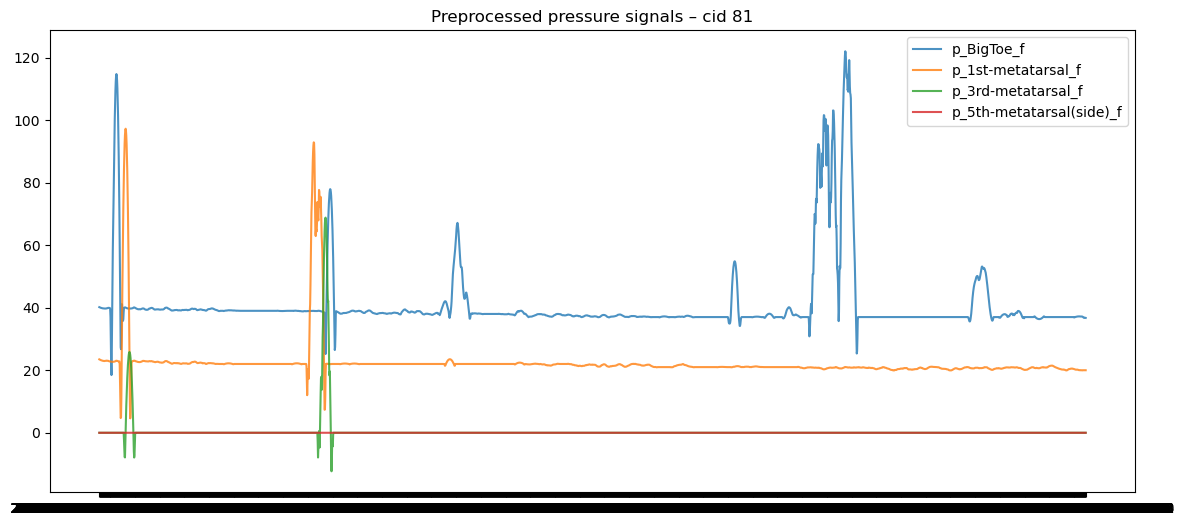

In [1]:
from matplotlib import pyplot as plt
import pandas as pd

df_vis = pd.read_csv("../data/capture_clean.csv")
cid = df_vis['cid'].value_counts().idxmax()
g = df_vis[df_vis['cid'] == cid].iloc[:3000]

plt.figure(figsize=(14,6))
for c in ["p_BigToe_f", "p_1st-metatarsal_f", "p_3rd-metatarsal_f", "p_5th-metatarsal(side)_f"]:
    plt.plot(g['t'], g[c], label=c, alpha=0.8)

plt.legend()
plt.title(f"Preprocessed pressure signals – cid {cid}")
plt.show()
